# <span style="color:#F72585"><center>Optimización multivariada usando JAX </center></span>

## <span style="color:#4361EE">Introducción</span> 

En este ejercicio generamos un conjunto de datos que sigue un modelo lineal, pasando por el origen. Lo datos son contaminado con un error normal $N(0,2^2)$.

## <span style="color:#4361EE">Carga módulos</span> 

In [1]:
from __future__ import print_function
import jax.numpy as np # autograd para windows
import numpy as onp
import matplotlib.pyplot as plt
from jax import grad,jit
import pandas as pd

## <span style="color:#4361EE">Genera y grafica datos simulados</span> 

In [5]:
# Simulación de datos

# Elegir una semilla
onp.random.seed(22)

# Generación de los datos
x=onp.linspace(-2,2,100)
y=3*x+5 + onp.random.normal(0,1,len(x))



data=pd.DataFrame({"Mediciones":x,"Observaciones":y})
data

,Mediciones,Observaciones
0,-2.000000,-1.091950
1,-1.959596,-2.342139
2,-1.919192,0.324216
3,-1.878788,-0.875689
4,-1.838384,-1.006281
...,...,...
95,1.838384,11.384497
96,1.878788,10.419599
97,1.919192,10.774694
98,1.959596,11.568501


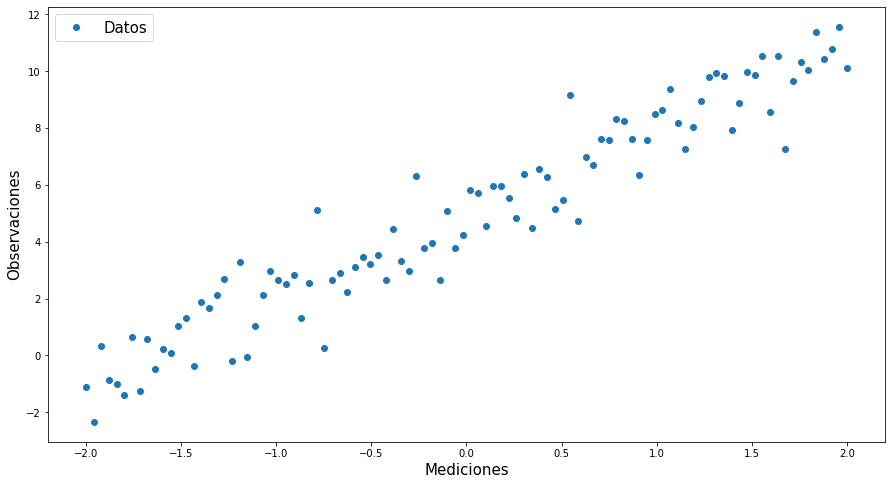

In [6]:
plt.figure(figsize=(15,8))
plt.plot(x,y,'o')
plt.xlabel("Mediciones",fontsize=15)
plt.ylabel("Observaciones",fontsize=15)
plt.legend(["Datos"],fontsize=15)
plt.show()

## <span style="color:#4361EE">Función de pérdida</span>  

In [9]:
def loss(β0,β1,x,y):
    return ((y-(β1*x+β0))**2).mean()

## Diferenciación Automática
grad_loss=jit(grad(loss,argnums=(0,1)))

## <span style="color:#4361EE">Gradiente descendiente </span>  

In [10]:
def grad_step(β0,β1,x,y,h=1.5):
    
    # Calcular Derivada
    β0_grad,β1_grad=grad_loss(β0,β1,x,y)
    
    # Gradiente Descendiente
    β1-=β1_grad*h
    β0-=β0_grad*h
    
    # Regresar Nuevos parámetros
    return β0,β1

## <span style="color:#4361EE">Optimización</span>  

In [39]:
## Estimación inicial
Β0,Β1 = 40.,40.

# Acumular resultados
β0,β1 = [],[]
train_loss = []
# Número de veces que se cambiar los parámetros
epochs=300

# Tasa de Aprendizaje
lr = 1.
# pérdida inicial (ficticia)
prev_loss = 10
# epsilon para parada temparana
epsilon = 1.0e-6

print("Perdidas:\n")

for epoch in range(epochs):
    
    Β0,Β1 = grad_step(Β0,Β1,x,y,lr)
    
    losss = loss(Β0,Β1,x,y)
    
    β0.append(Β0)
    β1.append(Β1)
    train_loss.append(losss)
    
    # parada anticipada
    if np.abs(prev_loss-losss) < epsilon:
        break
    
    prev_loss = losss
    lr = 1/(epoch+1)
    
    if epoch%5==0:
        print(f"Iteración {epoch}; pérdida = {losss}")
        

Perdidas:

Iteración 0; pérdida = 6747.9462890625
Iteración 5; pérdida = 1.3601689338684082
Iteración 10; pérdida = 0.9738378524780273
Iteración 15; pérdida = 0.9693822860717773
Iteración 20; pérdida = 0.9690168499946594
Iteración 25; pérdida = 0.9689546227455139
Iteración 30; pérdida = 0.9689388871192932


## <span style="color:#4361EE"> Parámetros finales </span>

In [40]:
epochs = epoch + 1
perdida_final = losss
gradiente_final = grad_loss(β0[-1],β1[-1], x, y)

print('Resultados finales')
print('(β0 = {}, β1 = {})'.format(β0[-1],β0[-1]))
print('epochs =', epochs)
print('pérdida final =', perdida_final)
print('gradiente final = [{},{}]'.format(gradiente_final[0],gradiente_final[1]))




Resultados finales
(β0 = 4.946324825286865, β1 = 4.946324825286865)
epochs = 35
pérdida final = 0.9689345
gradiente final = [4.544854164123535e-07,-0.004873543977737427]


## <span style="color:#4361EE"> Gráfica del modelo </span>

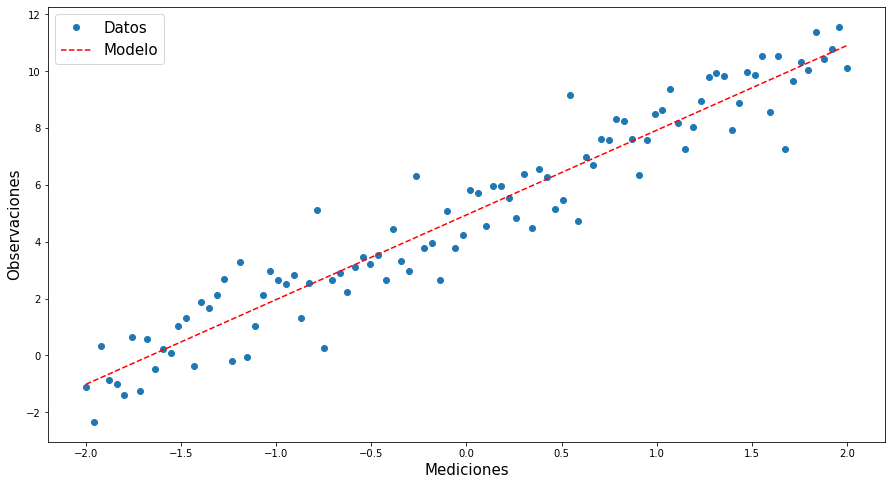

In [32]:
# Haciendo el modelo

mod  =β1[-1]*x + β0[-1]

plt.figure(figsize=(15,8))
plt.plot(x,y,'o')
plt.plot(x,mod,'r--')
plt.xlabel("Mediciones",fontsize=15)
plt.ylabel("Observaciones",fontsize=15)
plt.legend(["Datos","Modelo"],fontsize=15)
plt.show()

## <span style="color:#4361EE">Visualizando la función pérdida </span>  

In [41]:
# eje β (par.)
β0x = onp.linspace(β0[-1]-100,β0[-1]+100,100)
β1y = onp.linspace(β1[-1]-100,β1[-1]+100,100)

bx,by = onp.meshgrid(β0x,β1y)

l = onp.empty(shape=(len(β0x),len(β1y)))

for i in range(len(β0x)):
    for j in range(len(β1y)):
        l[i,j] = ((by[i,j]*x+bx[i,j]-y)**2).mean()

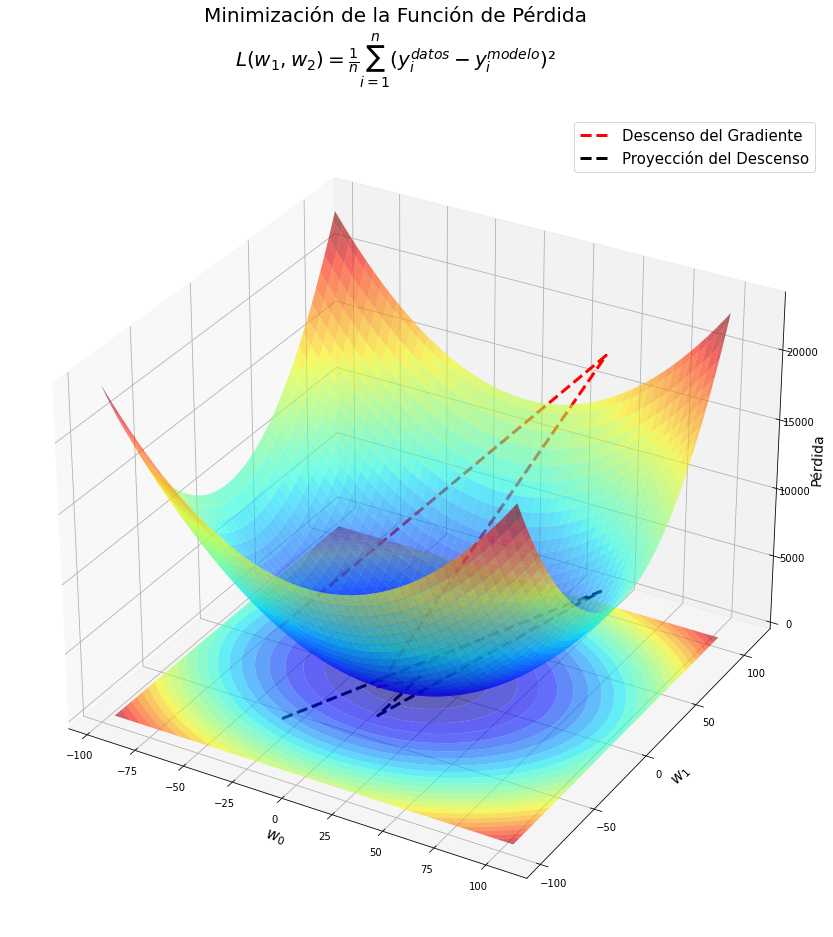

In [42]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(22,15))
plt.suptitle("Minimización de la Función de Pérdida\n"+r"$L( w_{1}, w_{2})=\frac{1}{n}\sum_{i=1}^{n}(y_i^{datos}-y_i^{modelo})²$",fontsize=20)
ax = plt.axes(projection='3d')

ax.plot_surface(bx,by,l,alpha=0.6,cmap='jet') # Superficie de pérdida

ax.plot(β0,β1,train_loss,'r--',lw=3,label="Descenso del Gradiente") # Ruta tomada por el optimizador
ax.contourf(bx,by,l,25,offset=-1,cmap='jet',alpha=0.6,antialiased=True) # Curvas de nivel de superficie
ax.plot(β0,β1,'k--',lw=3,label="Proyección del Descenso") # Proyección de la ruta

ax.set_xlabel(r"$w_0$",fontsize=15)
ax.set_ylabel(r"$w_1$",fontsize=15)
#ax.zaxis.set_rotate_label(False)  # deshabilitar la rotación automática
ax.set_zlabel("Pérdida",fontsize=14,rotation=90)
#ax.view_init(30, 100)
plt.legend(fontsize=15)
#plt.savefig('GD_3D.png')
plt.show()

In [43]:
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(22,15))
plt.suptitle("Minimización de la Función de Pérdida\n"+r"$L( w_{1}, w_{2})=\frac{1}{n}\sum_{i=1}^{n}(y_i^{datos}-y_i^{modelo})²$",fontsize=20)
ax = plt.axes(projection='3d')

ax.plot_surface(bx,by,l,alpha=0.6,cmap='jet') # Superficie de pérdida

ax.plot(β0,β1,train_loss,'r--',lw=3,label="Descenso del Gradiente") # Ruta tomada por el optimizador
ax.contourf(bx,by,l,25,offset=-1,cmap='jet',alpha=0.6,antialiased=True) # Curvas de nivel de superficie
ax.plot(β0,β1,'k--',lw=3,label="Proyección del Descenso") # Proyección de la ruta

ax.set_xlabel(r"$w_0$",fontsize=15)
ax.set_ylabel(r"$w_1$",fontsize=15)
#ax.zaxis.set_rotate_label(False)  # deshabilitar la rotación automática
ax.set_zlabel("Pérdida",fontsize=14,rotation=90)
#ax.view_init(30, 100)
plt.legend(fontsize=15)
#plt.savefig('GD_3D.png')
plt.show()

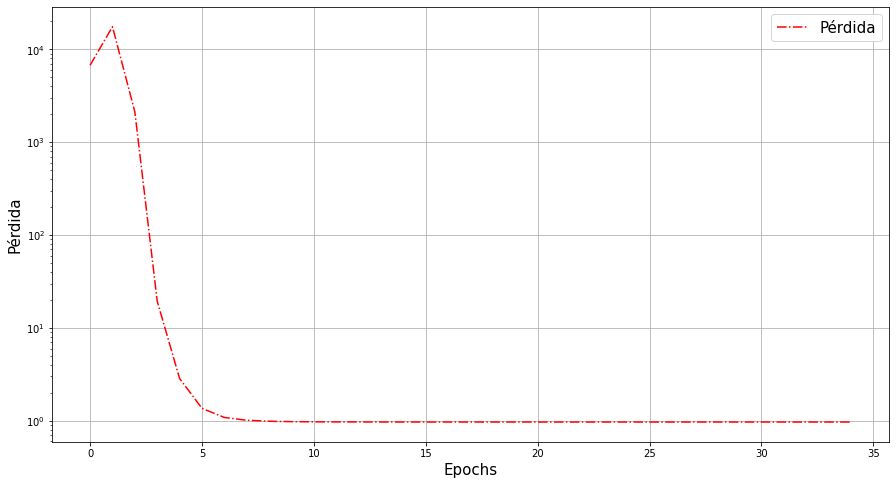

In [47]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.semilogy(range(epochs),train_loss,'r-.')
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Pérdida",fontsize=15)
plt.legend(["Pérdida"],fontsize=15)
plt.grid()
plt.show()

## <span style="color:#4361EE">Ejercicios</span>  

1. Escriba una clase que implemente la optimización de una función de dos variables.
1. Puebe su clase con la función $z=(1-x^2+y^3) e^{-(x^2+y^3)/2}$
1. Haga un gráfico de la función